# **Policy Gradient**

Policy gradients in reinforcement learning (RL) are a class of algorithms that directly optimize the agent’s policy by estimating the gradient of the expected reward with respect to the policy parameters. Based on policy gradient, here comes PPO, A2C and some policy-based RL algorithm.

Action space in RL can be discrete or continuous; however, value-based methods, like Q-learning, SARSA and DQN, are unable to deal with continuous RL problem with continuous action space, since curse of dimensionality will be a big issue hewn we build the Q-table or DNN model.

Policy gradient parameterize the policy and estimate the gradient of cumulative rewards with respect to he policy parameters. Gradient is used directly to ptimize the policy by updating the parameters. So by policy gradient, even we don't know the number available actions or action space is continuous, we still can modelize RL problem and overcome the curse of dimensionality, which enables better efficiency and more flexible exploration. Policy gradient is also a basis of RLHF (Reinforcement Learning using Human Feedback) method, which contributes a lot to AI chatbot.

### **Deterministic / Stochastic policy**

Given a observation:

* **Deterministic policy** will bring a specific action to take.

* **Stochastic policy** will give a probabiliy distribution that tell you the probability to that each action.

When using stochastic policy, the same observation can lead to take different action in different iterations, which improves the ability to explore the action space and avoid trapping in local optma.

Policy gradient tends to use stochastic policy, let agent to choose an action by sampling from action probility distribution, which conbine exploration and exploitation.

### **Terminology of policy gradient**

* $\pi_{\theta}$ is a policy with parameter set $\theta$, usualy $\theta$ represent the weights of neural network that model the policy.

* $\tau$ represents a trajectory which refers to a state set from initial state to terminal state.

* $J(\theta)$ represents the expected return when following the policy $\pi_{\theta}$. This is also an obective function for policy gradien ascent.

* $R(\tau)$ refers to the total reward over trajectory $\tau$.

## **Policy update**

As mentioned in above part, we can get a function like,     

$$J(\theta)=E_{\tau\sim\pi_{\theta}}[R(\tau)]=E_{\tau\sim\pi_{\theta}}[\sum_{t=1}^{T}r(s_t,a_t)]$$

Assumed that there are $N$ sampled trajectory, the objective function can be expressed as,  

$$J(\theta)=E_{\tau\sim\pi_{\theta}}[\sum_{t=1}^{T}r(s_t,a_t)]\approx\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T}r(s_t,a_t)$$

The goal of polcy update is to finc the opimal parameters $\theta$,   

$$\theta^{*}=\text{arg}\max_{\theta}E_{\tau\sim\pi_{\theta}}[\sum_{t=1}^{T}r(s_t,a_t)]$$

To optimize the objective function, we need get the differential of the objective function with respect to $\theta$   

$$\nabla_{\theta}J(\theta)=\nabla_{\theta}E_{\tau\sim\pi_{\theta}}[\sum_{t=1}^{T}r(s_t,a_t)]$$

And the expected return can be expressed as $\sum_{\tau}P(\tau|\theta)R(\tau)$ for discrete case, and $\int_{\tau}P(\tau|\theta)R(\tau)$ for continuous case, so the differential of the objective function can be rewritten as,   

$$\nabla_{\theta}J(\theta)=\nabla_{\theta}\sum_{\tau}P(\tau|\theta)R(\tau)$$  
or  
$$\nabla_{\theta}J(\theta)=\nabla_{\theta}\int_{\tau}P(\tau|\theta)R(\tau)$$

If breaking down the probability of a trajectory into the transition from inital state to terminal state, we can get the following equation,  

$$P(\tau|\theta)=\rho_0(s_0)\prod_{t=1}^{T}P(s_{t+1}|s_t,a_t)\pi_{\theta}(a_t|s_t)$$

For simplier calculation, we take the logarithm on both sides of the above equation,    

$$\log(P(\tau|\theta))=\log{\rho_0(s_0)}+\sum_{t=1}^{T}[\log(P(s_{t+1}|s_t,a_t))+\log(\pi_{\theta}(a_t|s_t))]$$

$$\nabla_{\theta}\log(P(\tau|\theta))=\nabla_{\theta}\log{\rho_0(s_0)}+\nabla_{\theta}\sum_{t=1}^{T}[\log(P(s_{t+1}|s_t,a_t))+\log(\pi_{\theta}(a_t|s_t))]$$

$$\nabla_{\theta}\log(P(\tau|\theta))=\nabla_{\theta}\sum_{t=1}^{T}[\log(\pi_{\theta}(a_t|s_t))]$$

So the differential of objective function can be rewritten again as,    

$$\nabla_{\theta}J(\theta)=E_{\tau\sim\pi_{\theta}}[(\sum_{t=1}^{T}\nabla_{\theta}log(\pi_{\theta}(a_t|s_t)))(\sum_{t=1}^{T}r(s_{t},a_{t}))]\approx\frac{1}{N}\sum_{i=1}^{N}[\sum_{t=1}^{T}\nabla_{\theta}log(\pi_{\theta}(a_{i,t}|s_{i,t}))]{\sum_{t=1}^{T}r(s_{i,t},a_{i,t})}$$

With the differntial of objective funtion, we can update policy parameters $\theta$ by, 

$$\theta_{t+1} \leftarrow \theta_{t}+\alpha\nabla_{\theta}J(\pi_{\theta})|_{\theta_{t}}$$


where $t$ is iteration count, $\alpha$ is learning rate.

## **Implementation**

For example, if there is a policy modeled as neural network, so the policy paramter is weights of neural network. By policy gradient, we can generate an optimal policy by iteratively updating the neural network weigths.
<img src="img/policy_gradient.png" width="600">

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import numpy as np

class network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(network, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        action = self.l3(x)
        return action
    

class PG:
    def __init__(self, env, n_state, hidden_dim, n_action, lr=0.01, gamma = 0.99,epsilon = 1.0, episodes = 100):
        self.env = env
        
        self.policy_net = network(n_state, hidden_dim, n_action)
        
        self.memory_counter = 0
        self.learn_step_counter = 0
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.episodes = episodes

        self.total_rewards = list()
        self.total_steps = list()

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            action = self.policy_net(state).max(1)[1].item()
        return action

    def training(self):
        for i in range(self.episodes):
            done = False
            states = []
            actions = []
            rewards = []
            s = self.env.reset()
            step = 0
            while not done:
                # Collect trajectory
                states.append(s)
                a = self.get_action(s)
                actions.append(a)
                next_state, reward, done, _ = self.env.step(a)
                rewards.append(reward)
                s = next_state
                step += 1
            done = False
            
            cum_rewards = np.zeros(len(rewards))
            for j in reversed(range(len(rewards))):
                cum_rewards[j] = rewards[j] + self.gamma * cum_rewards[j + 1] if j + 1 < len(rewards) else rewards[j]
            self.total_rewards.append(cum_rewards[0])
            self.total_steps.append(step)
            
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            cum_rewards = torch.FloatTensor(cum_rewards)

            self.optimizer.zero_grad()
            action_values = self.policy_net(states)
            log_probs = -F.cross_entropy(action_values, actions, reduction="none")

            loss = -torch.sum(log_probs * cum_rewards)
            loss.backward()
            self.optimizer.step()

            if i % 10 == 0:
                self.epsilon = max(0.01, self.epsilon * 0.99)  # Decay epsilon
            if i % 100 == 0:
                print(f'Episode {i} finished total reward: {cum_rewards[0]/step}, actual reward: {step}')

In [2]:
import gym

env = gym.make('CartPole-v1')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
hidden_dim = 64

pg = PG(env, n_state, hidden_dim, n_action, lr=0.01, gamma=0.99, epsilon=1.0, episodes=1000)
pg.training()

/var/folders/69/6ry3j72176v59y5slnc712gw0000gn/T/ipykernel_12981/1985127200.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 0 finished total reward: 0.7973122000694275, actual reward: 48
Episode 100 finished total reward: 0.9193680286407471, actual reward: 18
Episode 200 finished total reward: 0.8973291516304016, actual reward: 23
Episode 300 finished total reward: 0.9193680286407471, actual reward: 18
Episode 400 finished total reward: 0.9375299215316772, actual reward: 14
Episode 500 finished total reward: 0.3817443549633026, actual reward: 238
Episode 600 finished total reward: 0.4906294345855713, actual reward: 165
Episode 700 finished total reward: 0.28009042143821716, actual reward: 346
Episode 800 finished total reward: 0.7027884721755981, actual reward: 76
Episode 900 finished total reward: 0.4390430748462677, actual reward: 196


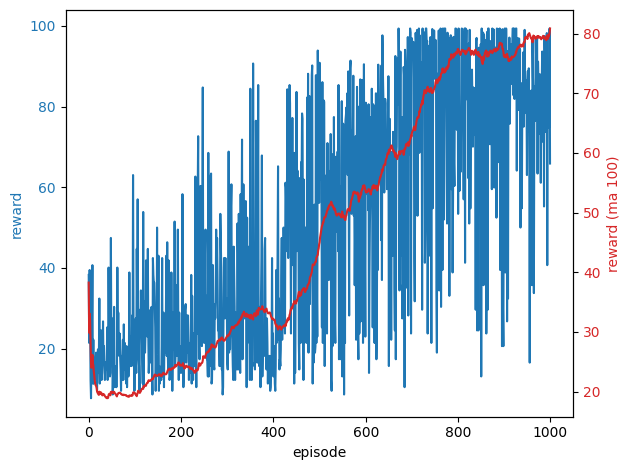

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def ma(x, window_len=10):
    res = list()
    for i in range(len(x)):
        if i < window_len:
            res.append(x[:i+1].mean())
        else:
            res.append(x[i-window_len:i].mean())
    return res

df = pd.DataFrame({'episode': range(pg.episodes), 'reward': pg.total_rewards, 'steps': pg.total_steps})
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('reward', color=color)
ax1.plot(df['episode'], df['reward'], color=color)
#ax1.plot(df['episode'], df['reward'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('reward (ma 100)', color=color)  # we already handled the x-label with ax1
ax2.plot(df['episode'], ma(df['reward'],100), color=color)
#ax2.plot(df['episode'], df['steps'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

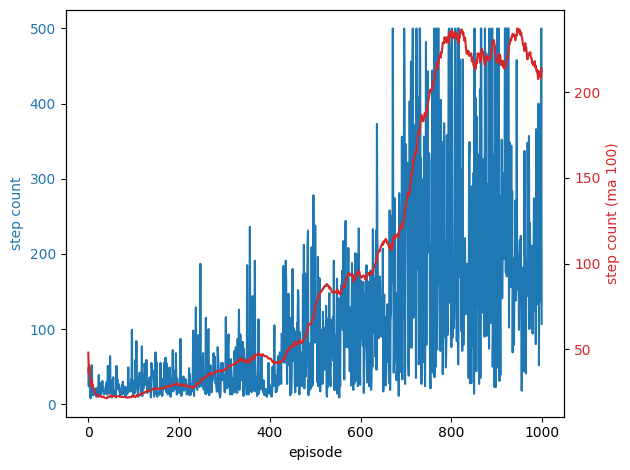

In [4]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('step count', color=color)
ax1.plot(df['episode'], df['steps'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('step count (ma 100)', color=color)  # we already handled the x-label with ax1
ax2.plot(df['episode'], ma(df['steps'],100), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Average test reward: -1.295581378580375
Average test step count: 317.86


Text(0, 0.5, 'Frequency')

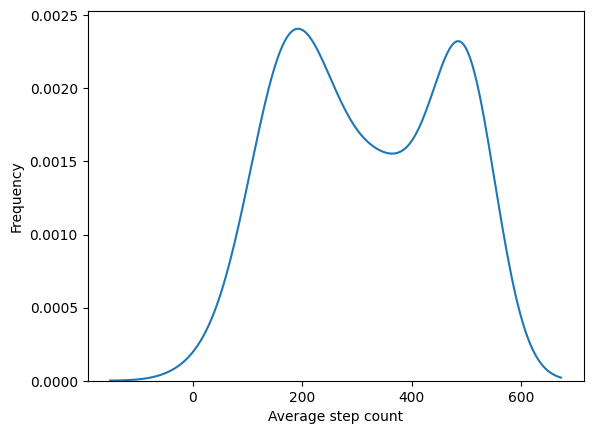

In [5]:
test_episodes = 100
test_rewards = []
test_steps = []
env = gym.make('CartPole-v1')

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0
    step = 0
    done = False
    
    while not done:
        action = pg.get_action(state)
        next_state, reward, done, _ = env.step(action)
        position, p_vel, angle, a_vel = next_state
        reward = -(abs(angle)/env.theta_threshold_radians + abs(position)/env.x_threshold + abs(p_vel) + abs(a_vel))  # Custom reward function
        episode_reward += reward
        step += 1
        state = next_state
    
    test_rewards.append(episode_reward/step)
    test_steps.append(step)
    #print(f'Test Episode {episode} finished with total reward: {episode_reward}')
env.close()


print('Average test reward:', np.mean(test_rewards))
print('Average test step count:', np.mean(test_steps))

import seaborn as sns
sns.kdeplot(test_steps,)
plt.xlabel('Average step count')
plt.ylabel('Frequency')